# 作业内容
利用随机森林,LR,SVM 解决泰坦尼克号问题

In [71]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble  import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import random
from sklearn.metrics import accuracy_score


In [72]:
train=pd.read_csv("./titanic/train.csv")
test=pd.read_csv("./titanic/test.csv")
# 合并数据集
combine = [train , test]
train.info()  
print("----"*30)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
------------------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          

# 数据字典
<br>
survival	Survival 存活与否	0 = No, 1 = Yes
<br>
pclass	Ticket class 座舱等级	1 = 1st, 2 = 2nd, 3 = 3rd
<br>
sex	gender 性别	
<br>
Age	Age in years 年龄	
<br>
sibsp	# of siblings / spouses aboard the Titanic 船上的兄弟姐妹或配偶个数	
<br>
parch	# of parents / children aboard the Titanic 船上的父母或子女个数	
<br>
ticket	Ticket number 票号	
<br>
fare	Passenger fare 票价	
<br>
cabin	Cabin number 座舱号
<br>
embarked	Port of Embarkation 登船港口	C = Cherbourg 瑟堡, Q = Queenstown 皇后镇, S = Southampton 南安普敦

In [73]:
# 处理数据
for dataset in combine:
    # 根据姓名新增特征
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # 性别特征数字化
    dataset['Sex']=dataset['Sex'].map({'male':1,'female':0}).astype(int)

pd.crosstab(train['Title'], train['Sex'])

Sex,0,1
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [74]:
# 缺省值处理
for dataset in combine:
    #年龄(Age)
    dataset['Age']=dataset['Age'].fillna( dataset['Age'].mean() )
    #船票价格(Fare)
    dataset['Fare'] = dataset['Fare'].fillna( dataset['Fare'].mean() )
    #缺失数据比较多，船舱号（Cabin）缺失值填充为U，表示未知（Uknow） 
    dataset['Cabin'] = dataset['Cabin'].fillna( 'U' )
    #登船港口,使用众数填充
    dataset['Embarked'] = dataset['Embarked'].fillna(dataset.Embarked.dropna().mode()[0])

train.info()  
print("----"*30)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null int32
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       891 non-null object
Title          891 non-null object
dtypes: float64(2), int32(1), int64(5), object(5)
memory usage: 87.1+ KB
------------------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null int32
Age     

In [75]:
# Name  特征列处理
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don',
                                                 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

train[['Title','Survived']].groupby(['Title'],as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [76]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,U,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,3
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,U,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,U,S,1


In [77]:
train = train.drop(['Name', 'PassengerId'], axis=1)
test= test.drop(['Name'], axis=1)
combine = [train, test]
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,0,3,1,22.0,1,0,A/5 21171,7.2500,U,S,1
1,1,1,0,38.0,1,0,PC 17599,71.2833,C85,C,3
2,1,3,0,26.0,0,0,STON/O2. 3101282,7.9250,U,S,2
3,1,1,0,35.0,1,0,113803,53.1000,C123,S,3
4,0,3,1,35.0,0,0,373450,8.0500,U,S,1


In [78]:
# 处理Age特征
train['AgeBand']=pd.cut(train['Age'],5)
train[['AgeBand','Survived']].groupby(['AgeBand'],as_index=False).mean().sort_values(by='AgeBand',ascending=True)

,AgeBand,Survived
0,"(0.34, 16.336]",0.550000
1,"(16.336, 32.252]",0.344168
2,"(32.252, 48.168]",0.404255
3,"(48.168, 64.084]",0.434783
4,"(64.084, 80.0]",0.090909


In [79]:
for dataset in combine:
    dataset.loc[dataset['Age']<=16,'Age']=0
    dataset.loc[(dataset['Age']>16) &(dataset['Age']<=32),'Age']=1
    dataset.loc[(dataset['Age']>32) &(dataset['Age']<=48),'Age']=2
    dataset.loc[(dataset['Age']>48) &(dataset['Age']<=64),'Age']=3
    dataset.loc[(dataset['Age']>64) ,'Age']=4

In [80]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,AgeBand
0,0,3,1,1.0,1,0,A/5 21171,7.2500,U,S,1,"(16.336, 32.252]"
1,1,1,0,2.0,1,0,PC 17599,71.2833,C85,C,3,"(32.252, 48.168]"
2,1,3,0,1.0,0,0,STON/O2. 3101282,7.9250,U,S,2,"(16.336, 32.252]"
3,1,1,0,2.0,1,0,113803,53.1000,C123,S,3,"(32.252, 48.168]"
4,0,3,1,2.0,0,0,373450,8.0500,U,S,1,"(32.252, 48.168]"


In [81]:
train = train.drop(['AgeBand'], axis=1)
combine = [train, test]
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,0,3,1,1.0,1,0,A/5 21171,7.2500,U,S,1
1,1,1,0,2.0,1,0,PC 17599,71.2833,C85,C,3
2,1,3,0,1.0,0,0,STON/O2. 3101282,7.9250,U,S,2
3,1,1,0,2.0,1,0,113803,53.1000,C123,S,3
4,0,3,1,2.0,0,0,373450,8.0500,U,S,1


In [82]:
# 处理SibSp，Parch 特征列
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [83]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [84]:
train = train.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test = test.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train, test]

train.head()

,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,IsAlone
0,0,3,1,1.0,A/5 21171,7.2500,U,S,1,0
1,1,1,0,2.0,PC 17599,71.2833,C85,C,3,0
2,1,3,0,1.0,STON/O2. 3101282,7.9250,U,S,2,1
3,1,1,0,2.0,113803,53.1000,C123,S,3,0
4,0,3,1,2.0,373450,8.0500,U,S,1,1


In [85]:
# 删除无用特征列
train = train.drop(['Ticket', 'Cabin'], axis=1)
test = test.drop(['Ticket', 'Cabin'], axis=1)
combine = [train, test]
train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,1,1.0,7.2500,S,1,0
1,1,1,0,2.0,71.2833,C,3,0
2,1,3,0,1.0,7.9250,S,2,1
3,1,1,0,2.0,53.1000,S,3,0
4,0,3,1,2.0,8.0500,S,1,1


In [86]:
# 处理Embarked特征，字符串转数值
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,1,1.0,7.2500,0,1,0
1,1,1,0,2.0,71.2833,1,3,0
2,1,3,0,1.0,7.9250,0,2,1
3,1,1,0,2.0,53.1000,0,3,0
4,0,3,1,2.0,8.0500,0,1,1


In [87]:
# 处理Fare船价特征
train['FareBand'] = pd.qcut(train['Fare'], 4)
train[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [88]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train= train.drop(['FareBand'], axis=1)
combine = [train, test]
    
train.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,1,1.0,0,0,1,0
1,1,1,0,2.0,3,1,3,0
2,1,3,0,1.0,1,0,2,1
3,1,1,0,2.0,3,0,3,0
4,0,3,1,2.0,1,0,1,1
5,0,3,1,1.0,1,2,1,1
6,0,1,1,3.0,3,0,1,1
7,0,3,1,0.0,2,0,4,0
8,1,3,0,1.0,1,0,3,0
9,1,2,0,0.0,2,1,3,0


In [89]:
test.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,892,3,1,2.0,0,2,1,1
1,893,3,0,2.0,0,0,3,0
2,894,2,1,3.0,1,2,1,1
3,895,3,1,1.0,1,0,1,1
4,896,3,0,1.0,1,0,3,0


In [90]:
X_train = train.drop("Survived", axis=1)
Y_train = train["Survived"]

train.sample(20)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
644,1,3,0,0.0,2,1,2,0
872,0,1,1,2.0,0,0,1,1
543,1,2,1,1.0,2,0,1,0
283,1,3,1,1.0,1,0,1,1
231,0,3,1,1.0,0,0,1,1
831,1,2,1,0.0,2,0,4,0
472,1,2,0,2.0,2,0,3,0
538,0,3,1,1.0,2,0,1,1
720,1,2,0,0.0,3,0,2,0
84,1,2,0,1.0,1,0,2,1


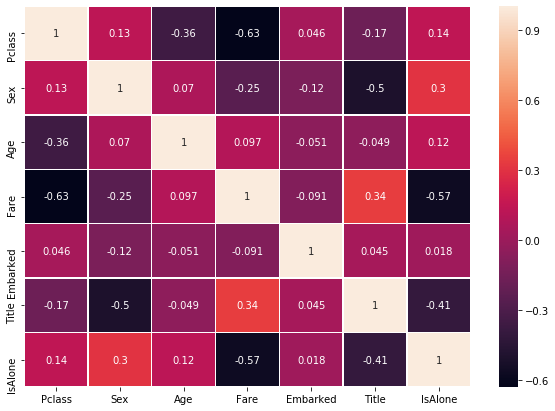

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=(10, 7),sharex=True)
sns.heatmap(X_train.corr(), annot=True, linewidths=.5, ax=axes)

In [92]:
# 从热力图可以看出，特征之间的相关性并不高，这说明这些模型特征可以很好的独立表示数据
X_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
Pclass      891 non-null int64
Sex         891 non-null int32
Age         891 non-null float64
Fare        891 non-null int32
Embarked    891 non-null int32
Title       891 non-null int64
IsAlone     891 non-null int64
dtypes: float64(1), int32(3), int64(3)
memory usage: 38.4 KB


In [93]:
def addScore(a_adaboost, a_gbdt, a_xgboost, a_lightgbm, name, score):
    if name == "lightgbm":
        a_lightgbm.append(score)
    elif name == "adaboost":
        a_adaboost.append(score)
    elif name == "gbdt":
        a_gbdt.append(score)
    elif name == "xgboost":
        a_xgboost.append(score)

In [94]:
from sklearn.model_selection import KFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score,mean_squared_error


X_train, X_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=0)
cls = [
    ('adaboost', AdaBoostClassifier()),
    ('gbdt', GradientBoostingClassifier()),
    ('xgboost', XGBClassifier()),
    ('lightgbm', lgb)
]

a_adaboost=[]
a_gbdt=[]
a_xgboost=[]
a_lightgbm=[]
for clf in cls:

    curr_score = 0
    for train_index, valid_index in kf.split(X_train):
        if (clf[0] == "lightgbm"):
            
            # 创建成lgb特征的数据集格式
            lgb_train = lgb.Dataset(X_train.iloc[train_index], y_train.iloc[train_index])
            # 将数据保存到LightGBM二进制文件将使加载更快
            # 创建验证数据
            lgb_eval = lgb.Dataset(X_train.iloc[valid_index], y_train.iloc[valid_index], reference=lgb_train)
            # 将参数写成字典下形式
            params = {
            'task': 'train',
            'boosting_type': 'gbdt',  # 设置提升类型
            'objective': 'binary',  # 目标函数
            'metric': {'l2', 'auc'},  # 评估函数
            'num_leaves': 25,  # 叶子节点数
            'learning_rate': 0.05,  # 学习速率
            'feature_fraction': 0.9,  # 建树的特征选择比例
            'bagging_fraction': 0.8,  # 建树的样本采样比例
            'bagging_freq': 5,  # k 意味着每 k 次迭代执行bagging
            'verbose': 0  # <0 显示致命的, =0 显示错误 (警告), >0 显示信息
        }
 

            # 训练 cv and train
            gbm = lgb.train(params, lgb_train, num_boost_round=20, valid_sets=lgb_eval,
                        early_stopping_rounds=5)  # 训练数据需要参数列表和数据集
            # 获得预测数据
            y_pred_new = gbm.predict(X_train.iloc[valid_index], num_iteration=gbm.best_iteration)
            # 保存模型以供后面使用
            gbm.save_model('model.txt')
            y_pred=[]
            for pred in y_pred_new:
                result = 1 if pred > 0.5 else 0
                y_pred.append(result)

        else:
            clf[1].fit(X_train.iloc[train_index], y_train.iloc[train_index])
            y_pred = clf[1].predict(X_train.iloc[valid_index])
            
        # 获得模型准确率
        accuracy = accuracy_score(y_train.iloc[valid_index], y_pred)
        # 使用测试数据验证模型
        curr_score = curr_score + accuracy
        addScore(a_adaboost,a_gbdt,a_xgboost,a_lightgbm,clf[0],accuracy)
      

    avg_score = curr_score / 5
    addScore(a_adaboost,a_gbdt,a_xgboost,a_lightgbm,clf[0],avg_score)
  
    
    if (clf[0] == "lightgbm"):
        # 模型加载
        gbm = lgb.Booster(model_file='model.txt')
        y_pred_new = gbm.predict(X_test, num_iteration=gbm.best_iteration)
        y_pred=[]
        for pred in y_pred_new:
            result = 1 if pred > 0.5 else 0
            y_pred.append(result)
    else:
        y_pred = clf[1].predict(X_test)

    # 获得测试集准确率
    test_accuracy = accuracy_score(y_pred, y_test)
    addScore(a_adaboost,a_gbdt,a_xgboost,a_lightgbm,clf[0],test_accuracy)
#     print("模型", clf[0], "训练集的准确率:", avg_score, " 验证集的准确率:", test_accuracy)
#     print(a_adaboost)
#     print(a_gbdt)
#     print(a_xgboost)
#     print(a_lightgbm)



[1]	valid_0's auc: 0.788929	valid_0's l2: 0.241897
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.788132	valid_0's l2: 0.234331
[3]	valid_0's auc: 0.807049	valid_0's l2: 0.228197
[4]	valid_0's auc: 0.810434	valid_0's l2: 0.222737
[5]	valid_0's auc: 0.81143	valid_0's l2: 0.217879
[6]	valid_0's auc: 0.818797	valid_0's l2: 0.211976
[7]	valid_0's auc: 0.81591	valid_0's l2: 0.20711
[8]	valid_0's auc: 0.823477	valid_0's l2: 0.203653
[9]	valid_0's auc: 0.814715	valid_0's l2: 0.199689
[10]	valid_0's auc: 0.822879	valid_0's l2: 0.195632
[11]	valid_0's auc: 0.826464	valid_0's l2: 0.192335
[12]	valid_0's auc: 0.826065	valid_0's l2: 0.189828
[13]	valid_0's auc: 0.826464	valid_0's l2: 0.187635
[14]	valid_0's auc: 0.825269	valid_0's l2: 0.185964
[15]	valid_0's auc: 0.823078	valid_0's l2: 0.184274
[16]	valid_0's auc: 0.824373	valid_0's l2: 0.182377
Early stopping, best iteration is:
[11]	valid_0's auc: 0.826464	valid_0's l2: 0.192335
[1]	valid_0's auc: 0.83086	valid_

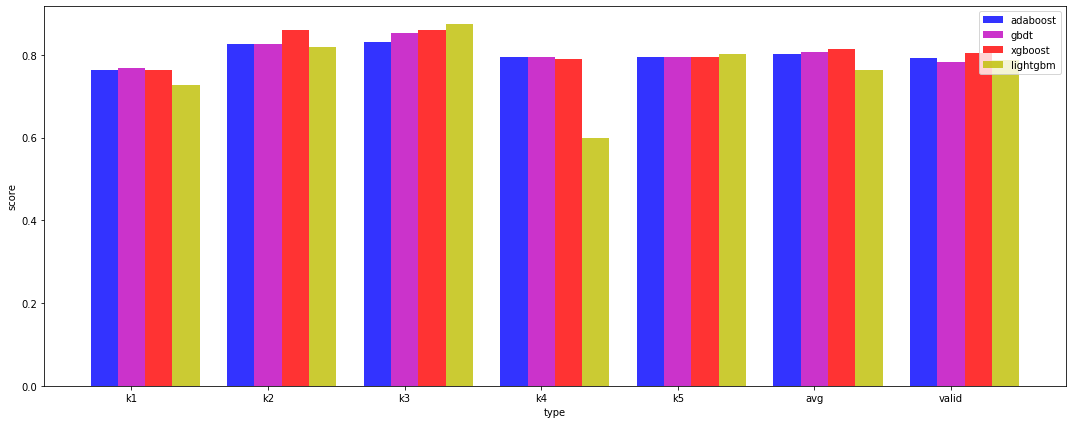

In [98]:
from pylab import mpl


fig, ax = plt.subplots(figsize=(15, 6))
 
index = np.arange(7)
bar_width = 0.2
 
opacity = 0.8
error_config = {'ecolor': '0.3'}
 
rects1 = ax.bar(index, np.array(a_adaboost), bar_width,
                alpha=opacity, color='b',
                error_kw=error_config,
                label='adaboost')
 
rects2 = ax.bar(index + bar_width, a_gbdt, bar_width,
                alpha=opacity, color='m',
                error_kw=error_config,
                label='gbdt')
 
rects3 = ax.bar(index + bar_width + bar_width, a_xgboost, bar_width,
                alpha=opacity, color='r',
                error_kw=error_config,
                label='xgboost')
 
rects4 = ax.bar(index + bar_width + bar_width+bar_width , a_lightgbm, bar_width,
                alpha=opacity, color='y',
                error_kw=error_config,
                label='lightgbm')

ax.set_xticks(index + 4 * bar_width / 4)
ax.set_xticklabels(('k1', 'k2', 'k3', 'k4', 'k5','avg','valid'))
ax.legend()
# 中文乱码问题解决方案
# zhfont= matplotlib.font_manager.FontProperties(fname='C:\Windows\Fonts\simsun.ttc')
# plt.xlabel("type", fontproperties=zhfont)
# plt.ylabel('score',fontproperties=zhfont)
plt.xlabel("type")
plt.ylabel('score')
 
fig.tight_layout()
plt.savefig('result.png', dpi=200)
plt.show()


In [99]:
from sklearn.model_selection import GridSearchCV #网格搜索
from sklearn.externals import joblib
param_grid = {

}

# 上面图k1代表KFlod交叉验证在不同的划分点各个模型的准确率，avg代表KFlod平均准确率，
#Valid代表验证集中模型准确率，根据综合评估，xgboost总体效果要好

gsearch = GridSearchCV(XGBClassifier( learning_rate =0.01,gamma=0.001,max_depth=4,min_child_weight=3,objective= 'binary:logistic',seed=27),param_grid,scoring = 'roc_auc',n_jobs = -1,cv=5)
gresult=gsearch.fit(X_train,y_train)


print("Best: %f using %s" % (gresult.best_score_,gresult.best_params_))

y_pred = gsearch.predict(X_test)
joblib.dump(gsearch, 'xgboost.pkl')
#获得测试集准确率
test_accuracy = accuracy_score(y_pred, y_test)
print("valid数据集准确率 %f" % (test_accuracy))

Best: 0.855218 using {}
valid数据集准确率 0.815642


[0.11738274 0.512265   0.00466074 0.02284036 0.01893079 0.32201174
 0.00190868]


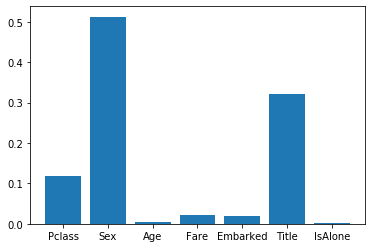

In [100]:
# 特征重要度展示
from matplotlib import pyplot
model=joblib.load('xgboost.pkl')
print(model.best_estimator_.feature_importances_)
pyplot.bar(X_train.columns, model.best_estimator_.feature_importances_)
pyplot.show()


In [ ]:

sub = pd.DataFrame()
sub['PassengerId'] = test['PassengerId']
sub['Survived'] =model.predict(test.drop('PassengerId',axis=1))
sub.to_csv('submit.csv', index=False)